# Sequence NLP model with IMDB dataset

* IMDB dataset (http://ai.stanford.edu/~amaas/data/sentiment/): Movie review sentences classified as positive or negative. 25,000 traning set, and 25,000 testing set.
* Different types of sequence and convolutional models tested: LSTM, GRU, and 1D convolution.

## Download IMDB dataset

In [1]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [2]:
tf.enable_eager_execution()

In [4]:
import tensorflow_datasets as tfds

In [6]:
imdb, info = tfds.load("imdb_reviews",with_info=True,as_supervised=True)

W0803 20:43:50.926373 140734767707584 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


## Tokenizing the dataset

* Classification for training and testing data set

In [7]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

# Training
training_sentences = []
training_labels = []

# Testing/Validation
testing_sentences = []
testing_labels = []

# S and l is originally in tf.Tensor format, converting them to numpy arrays
for s,l in train_data:
    training_sentences.append(str(s.numpy())) 
    training_labels.append(l.numpy())

for s,l in test_data:
    testing_sentences.append(str(s.numpy()))
    testing_labels.append(l.numpy())

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

* Tokenizing both training and testing set
* Padding the sequences to the same length

In [8]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Creating tokenizer with training sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

# Word-index and Index-word dictionaries
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

# Training padded sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Testing padded sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

## Long short term memory (LSTM)

* Instead of simply using flattening, LSTM layer is included after the word embedding
* Total parameters ~ 166k
* LSTM can remember long-distance relationship by the combination of recursion neural network (RNN), cells, and three gates (input, forget, and output).

In [22]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model1.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 120, 16)           160000    
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                6272      
_________________________________________________________________
dense_20 (Dense)             (None, 6)                 198       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 7         
Total params: 166,477
Trainable params: 166,477
Non-trainable params: 0
_________________________________________________________________


* Traning
* It took ~ 170 s per epoch, which is much slower than simple model without LSTM layer.

In [23]:
num_epochs = 20
history1 = model1.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 160s 6ms/sample - loss: 0.4793 - acc: 0.7572 - val_loss: 0.3698 - val_acc: 0.8404

* Plotting traning history
* The training result is similar to the simple model without LSTM.
1) Traning accuracy can be up to 0.994.
2) Validation accuracy does not slightly decreases with traning (still > 0.8), while the validation loss continuously increases, indicating the decrease in the prediction confidence, indicating overfitting.


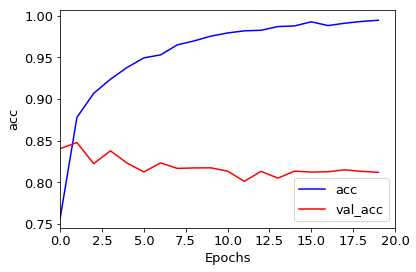

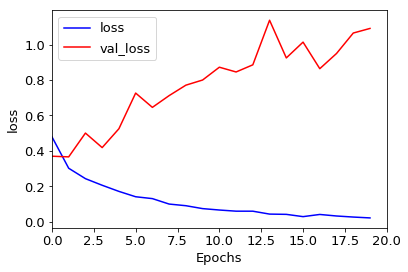

In [27]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    font = 13
    plt.plot(history.history[string],'b')
    plt.plot(history.history['val_'+string],'r')
    plt.xlabel("Epochs", fontsize=font)
    plt.ylabel(string, fontsize=font)
    plt.legend([string, 'val_'+string], fontsize=font)
    plt.xlim([0,num_epochs])
    #plt.ylim([-0.1,1.1])
    plt.xticks(fontsize=font)
    plt.yticks(fontsize=font)
    plt.show()

plot_graphs(history1, "acc")
plot_graphs(history1, "loss")

## Gated recurrent unit (GRU)

* Here GRU is used instead of LSTM. ~ 164k parameters, slightly lower than LSTM. Most of the parameters come from word embedding.
* GRU has only 2 gates (update and reset gates), while LSTM has 3 gates (input, output, forget gates).
* GRU is simpler, and can be trained faster than LSTM.
* In theory, LSTM should outperform GRU for longer sentences.

In [30]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model2.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 120, 16)           160000    
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                4704      
_________________________________________________________________
dense_24 (Dense)             (None, 6)                 198       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 7         
Total params: 164,909
Trainable params: 164,909
Non-trainable params: 0
_________________________________________________________________


* Training
* The training time is ~ 150 s  per epoch, which is ~ 20 s shorter than LSTM.

In [31]:
num_epochs = 20
history2 = model2.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 157s 6ms/sample - loss: 0.5496 - acc: 0.7046 - val_loss: 0.3865 - val_acc: 0.8323

* Plotting training history
* The trend in training is very similar to LSTM.
* Fluctuation in the validation accuracy and loss is smaller.

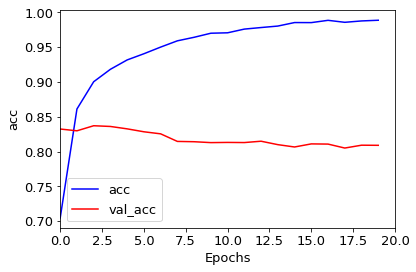

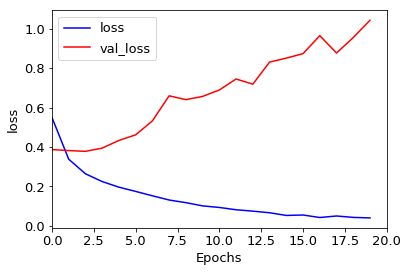

In [32]:
plot_graphs(history2, "acc")
plot_graphs(history2, "loss")

## 1D Convolution

* Here we use 1D convolution layers to extract the connection of neighbor words.
* Additional global average pooling added after the convoalution layer.
* Total parameters ~ 171 k.

In [36]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model3.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 120, 16)           160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 6)                 774       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
_________________________________________________________________


* Training
* Training time is only ~ 10 s, which is much shorter than LSTM and GRU.

In [37]:
num_epochs = 20
history3 = model3.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 10s 397us/sample - loss: 0.4394 - acc: 0.7887 - val_loss: 0.3443 - val_acc: 0.8510

* Plotting training history
* The trend in training is very similar to the other two model, but the validation loss increases faster, which means simple convolution is prone to overfitting, compared to more complicated sequence models.
* The maximum length of setences used for training is 120. For longer sentences, LSTM and GRU should outperform this simple convolutoin model.

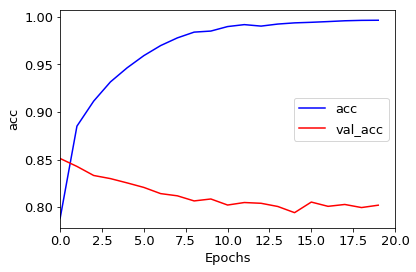

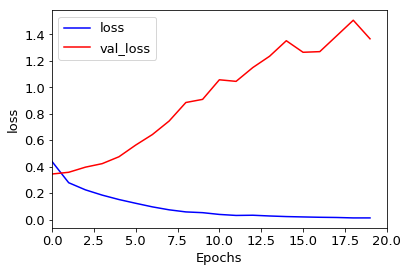

In [38]:
plot_graphs(history3, "acc")
plot_graphs(history3, "loss")